In [1]:
import os
import sys
import xarray as xr
import dask
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata


In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

c:\Users\marti\Desktop\data\hw_extra


In [3]:
ua_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Amon/ua/'pressure_level=85000'/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
ta_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Amon/ta/'pressure_level=85000'/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
psl_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Amon/psl/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
tos_e3 = xr.open_mfdataset("data/EC-Earth3/historical/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01","2014-12"))

In [4]:
def regrid_tos_ocean_curvilinear(ds):
    tos = ds["tos"]  # (time, j, i)
    lat2d = ds["latitude"].values
    lon2d = ds["longitude"].values
    time = ds["time"]

    # === Flatten source grid and build KDTree ===
    source_points = np.column_stack((lat2d.ravel(), lon2d.ravel()))
    tree = cKDTree(source_points)

    # === Create regular grid ===
    lat_new = np.arange(-90, 90.5, 0.5)
    lon_new = np.arange(0, 360, 0.5)
    lon_grid, lat_grid = np.meshgrid(lon_new, lat_new)
    target_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

    # === Map target points to nearest source points ===
    _, idx = tree.query(target_points)
    j_src, i_src = np.unravel_index(idx, lat2d.shape)

    # === Use broadcasting to grab all times in one shot ===
    tos_values = tos.values + 273.15  # shape (time, j, i) + to Kelvin
    tos_interp = tos_values[:, j_src, i_src]  # shape (time, n_points)
    tos_interp = tos_interp.reshape(len(time), len(lat_new), len(lon_new))

    # === Build xarray Dataset ===
    tos_da = xr.DataArray(
        tos_interp,
        dims=("time", "latitude", "longitude"),
        coords={
            "time": time,
            "latitude": lat_new,
            "longitude": lon_new,
        },
        name="tos"
    )
    tos_da.attrs = ds["tos"].attrs

    tos_e3_regridded = xr.Dataset({"tos": tos_da})
    tos_e3_regridded.attrs = ds.attrs

    return tos_e3_regridded

In [5]:
ua_e3 = ua_e3.rename({
    "lat": "latitude",
    "lon": "longitude"
})
ta_e3 = ta_e3.rename({
    "lat": "latitude",
    "lon": "longitude"
})
psl_e3 = psl_e3.rename({
    "lat": "latitude",
    "lon": "longitude"
})
tos_e3_regridded = regrid_tos_ocean_curvilinear(tos_e3)


adv_850_e3 = -1*ua_e3.ua*ta_e3.ta
adv_850_e3 = xr.Dataset({"adv": adv_850_e3})

In [6]:
ref_period = [1980,2010]
boxes_pacific = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "ocean_pressure": [260, 284, -44, -17], #study max over time and define region
    "chile" : [286, 288, -42, -33]
    #"advección": [280, 285, -37, -30]
}
boxes_chile_vaguada = {
    "b": [286, 288.5, -33, -28],
    "A_cl": [280, 286, -38,-30], #test bigger A boxes
    "A_arg": [291, 295, -38, -30]
}
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}
boxes_chile_winds = {
    "chile_u_norte": [287.5, 289.5, -37, -33],
    "chile_u_sur": [286.5, 288.5, -42, -37],
    "A_arg": [286, 292, -52, -40]
}

In [7]:
nino34_e3 = AnomaliesIndex(tos_e3_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_e3 = AnomaliesIndex(tos_e3_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")

mslp_indices_e3 = [psl_e3.sel(latitude=slice(box[2],box[3]),
                           longitude=slice(box[0], box[1])
                           ).psl.mean(dim=["latitude","longitude"]) for key,box in boxes_chile_vaguada.items()]

advection_indices_e3 = [AnomaliesIndex(adv_850_e3, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(adv_850_e3, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]

chile_wind_north_e3 = ua_e3.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
                           ).ua.mean(dim=["latitude","longitude"]
                           )

chile_wind_south_e3 = ua_e3.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1]), 
                           ).ua.mean(dim=["latitude","longitude"]
                           )
chile_wind_pressure_e3 = psl_e3.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
                           longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])).psl.mean(dim=["latitude","longitude"]
                           )
ocean_cyclone_e3 = MaxIndex(psl_e3, [1972,2022], variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=False)


In [8]:
tos_e3_regridded.sel(latitude=slice("-40", "-50"))

<xarray.Dataset> Size: 274MB
Dimensions:    (time: 528, latitude: 180, longitude: 720)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1971-01-16T12:00:00 ... 2014-12-16T1...
  * latitude   (latitude) float64 1kB -90.0 -89.5 -89.0 -88.5 ... -1.5 -1.0 -0.5
  * longitude  (longitude) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
Data variables:
    tos        (time, latitude, longitude) float32 274MB nan nan ... 302.5 302.6
Attributes: (12/48)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    branch_time:                        0.0
    comment:                            Production: Thomas Reerink at KNMI
    contact:                            cmip6-data@ec-earth.org
    ...                                 ...
    cmor_version:                       3.5.0
    tracking_id:                        hdl:21.14100/f7853bc0-57f9-448b-a470-...
    branch_time_in_child:               0.0D
    branch_time_in_parent:              149749.0D
    history:                            2019-09-26T09:10:49Z ; CMOR rewrote d...
    latest_applied_cmor_fixer_version:  v3.0

### Advection

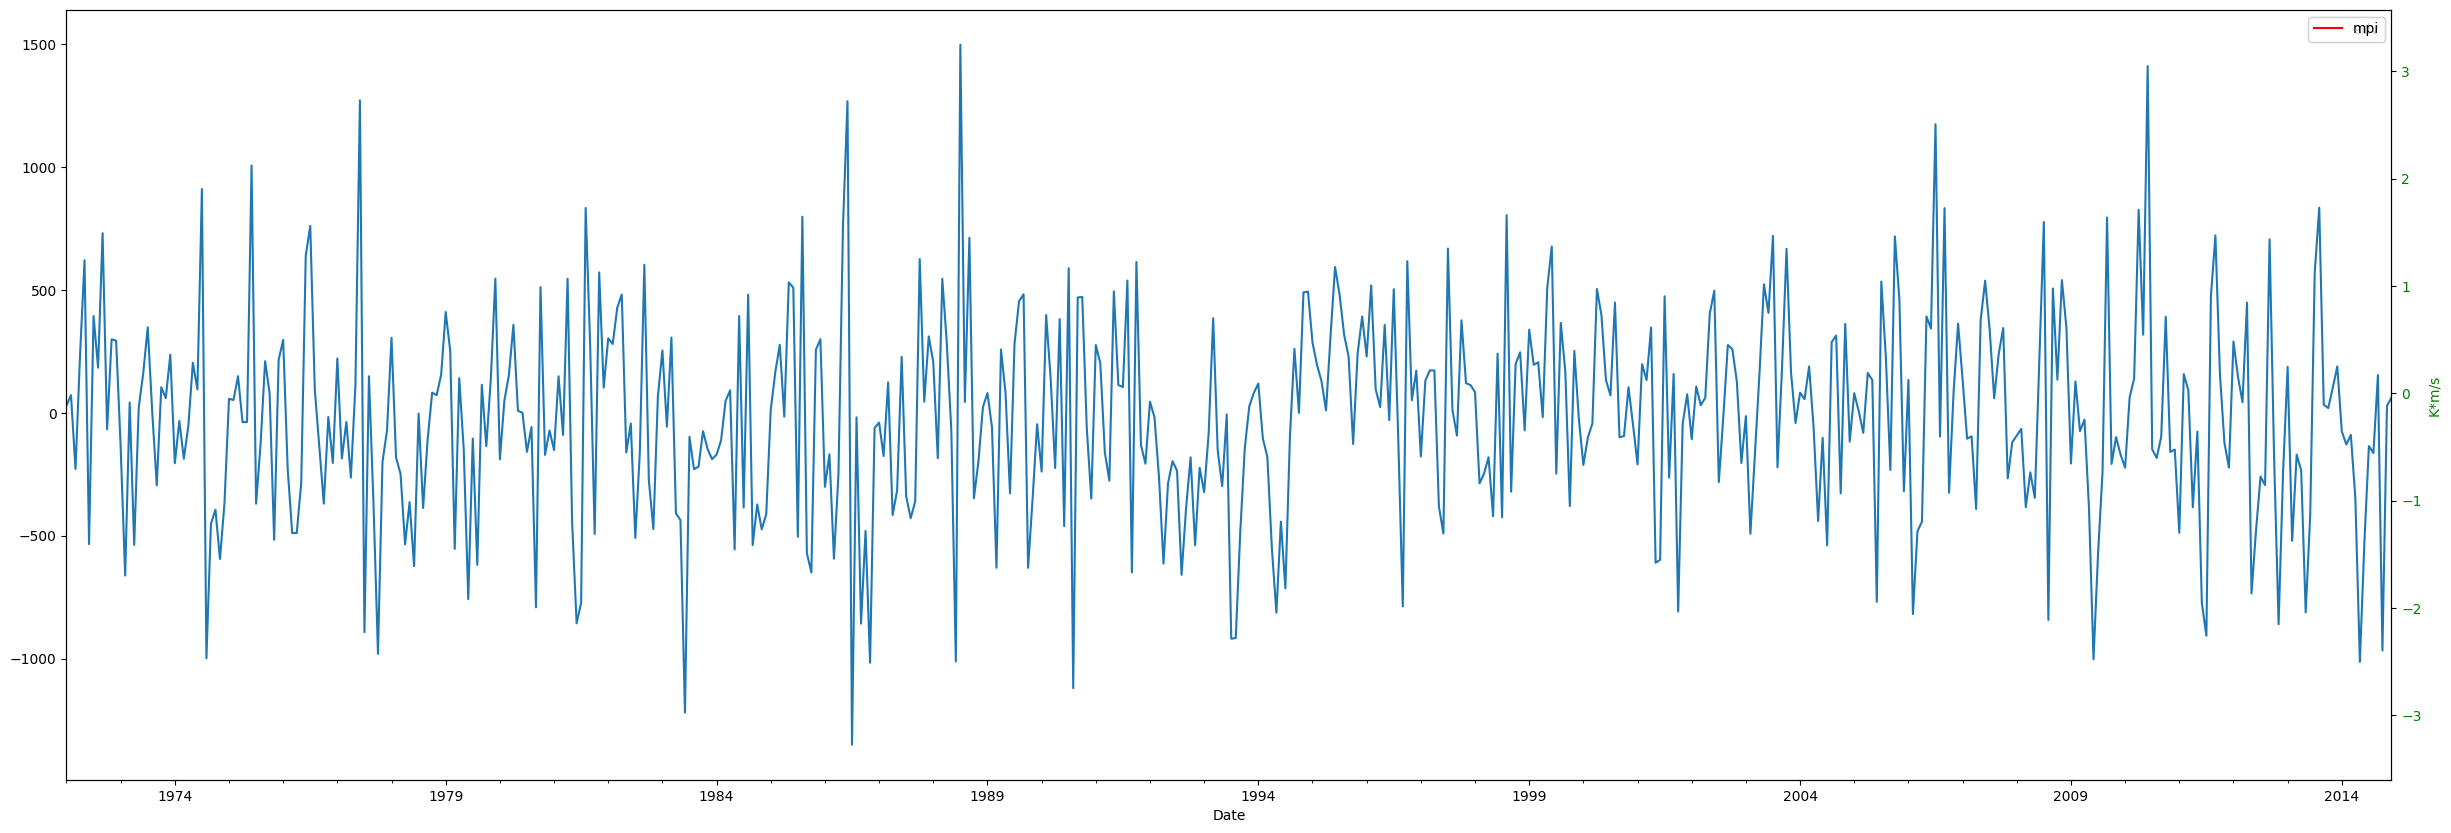

In [9]:
fig, ax = plt.subplots(figsize=(30,10))

ds_advmean = xr.open_mfdataset("data/03_primary/drivers/cmip6/EC-Earth3/historical/advection_mean/default/monthly/*.nc").sel(time=slice("1972-01", "2014-12"))

advection_indices_e3[1].get_index("ADV").plot(y="adv", ax=ax)
# Second Y-axis (right side)
ax2 = ax.twinx()
ax2.plot(ds_advmean.time, ds_advmean.advection_mean_in_box, color='red', label='mpi')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.legend()
plt.show()


### High Low Diff

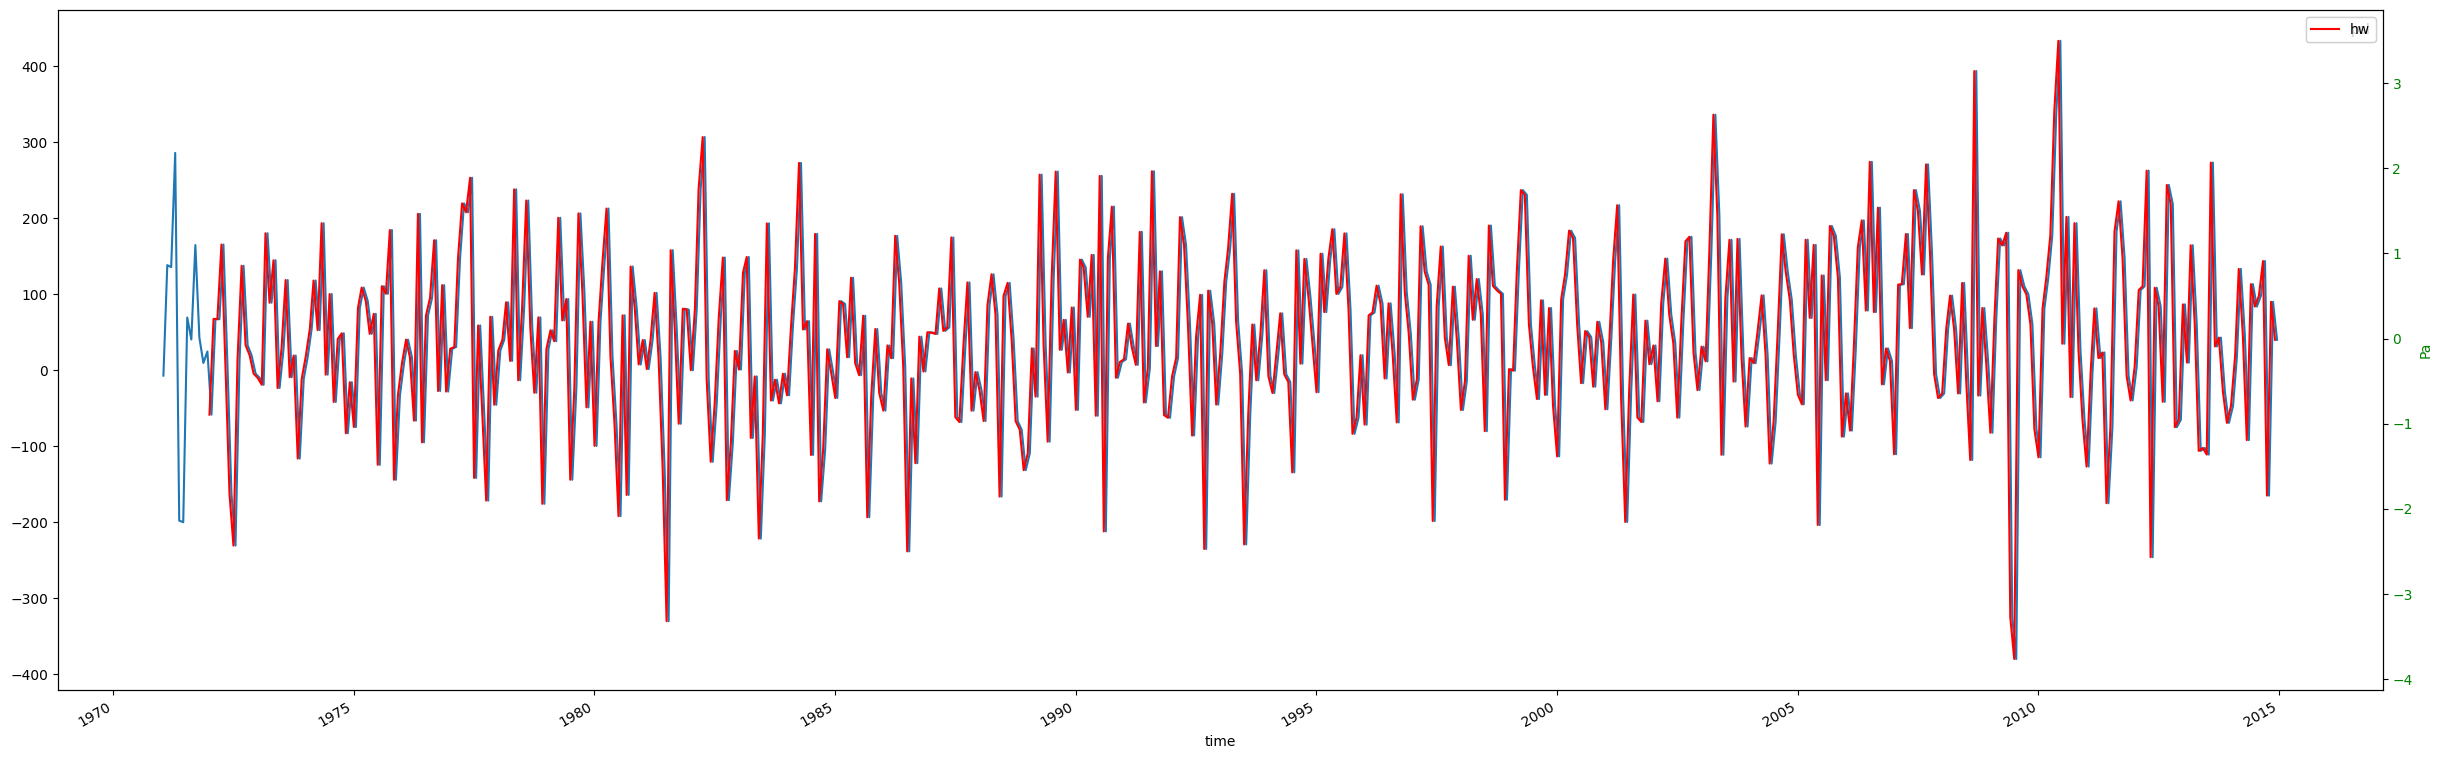

In [10]:
fig, ax = plt.subplots(figsize=(30,10))

ds_highlow = xr.open_mfdataset("data/03_primary/drivers/cmip6/EC-Earth3/historical/high_low_difference/normalized_diff/monthly/*.nc").sel(time=slice("1972-01", "2014-12"))
vaguada_e3 = (mslp_indices_e3[1]+mslp_indices_e3[2])/2 - mslp_indices_e3[0]

vaguada_e3.to_dataframe().plot(y="psl", ax=ax)
# Second Y-axis (right side)
ax2 = ax.twinx()
ax2.plot(ds_highlow.time, ds_highlow.high_low_difference, color='red', label='hw')
ax2.set_ylabel('Pa', color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.legend()
plt.show()


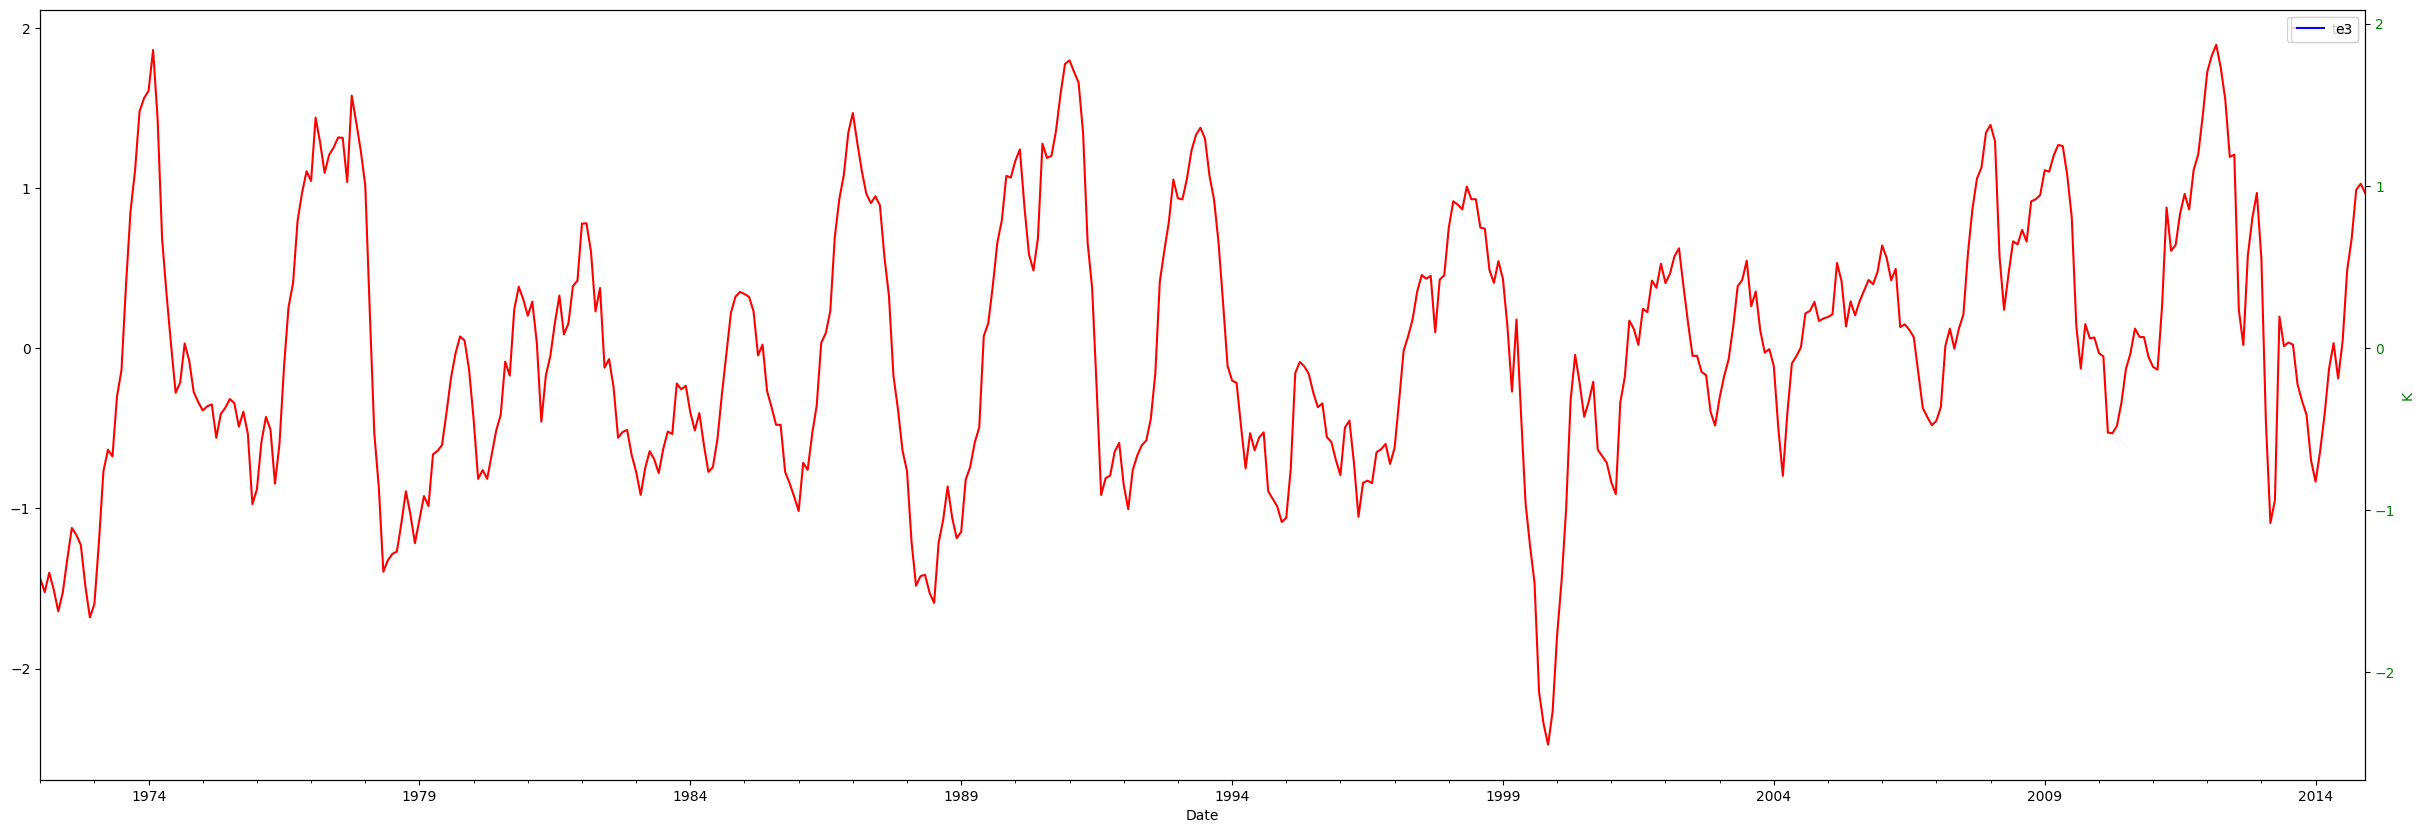

In [11]:
fig, ax = plt.subplots(figsize=(30,10))

ds_nino = xr.open_mfdataset("data/03_primary/drivers/cmip6/EC-Earth3/historical/local_climate/nino34/monthly/*.nc").sel(time=slice("1972-01", "2014-12"))

nino34_e3.get_index("TOS").plot(y="tos", ax=ax, color='red')
# Second Y-axis (right side)
ax2 = ax.twinx()
ax2.plot(ds_nino.time, ds_nino.region_tos_mean, color='blue', label='e3')
ax2.set_ylabel('K', color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.legend()
plt.show()


### Anticyclone

In [15]:
ocean_cyclone_e3.get_index("psl")

,max_value,latitude,longitude
Date,,,
1972-01-01,102081.757812,-34.736767,260.156250
1972-02-01,102057.015625,-34.736767,260.156250
1972-03-01,101693.039062,-31.929757,260.156250
1972-04-01,102211.023438,-36.140271,260.156250
1972-05-01,102416.789062,-33.333262,266.484375
...,...,...,...
2014-08-01,102095.218750,-27.017488,265.078125
2014-09-01,102126.179688,-31.929757,273.515625
2014-10-01,102045.398438,-27.719241,260.156250


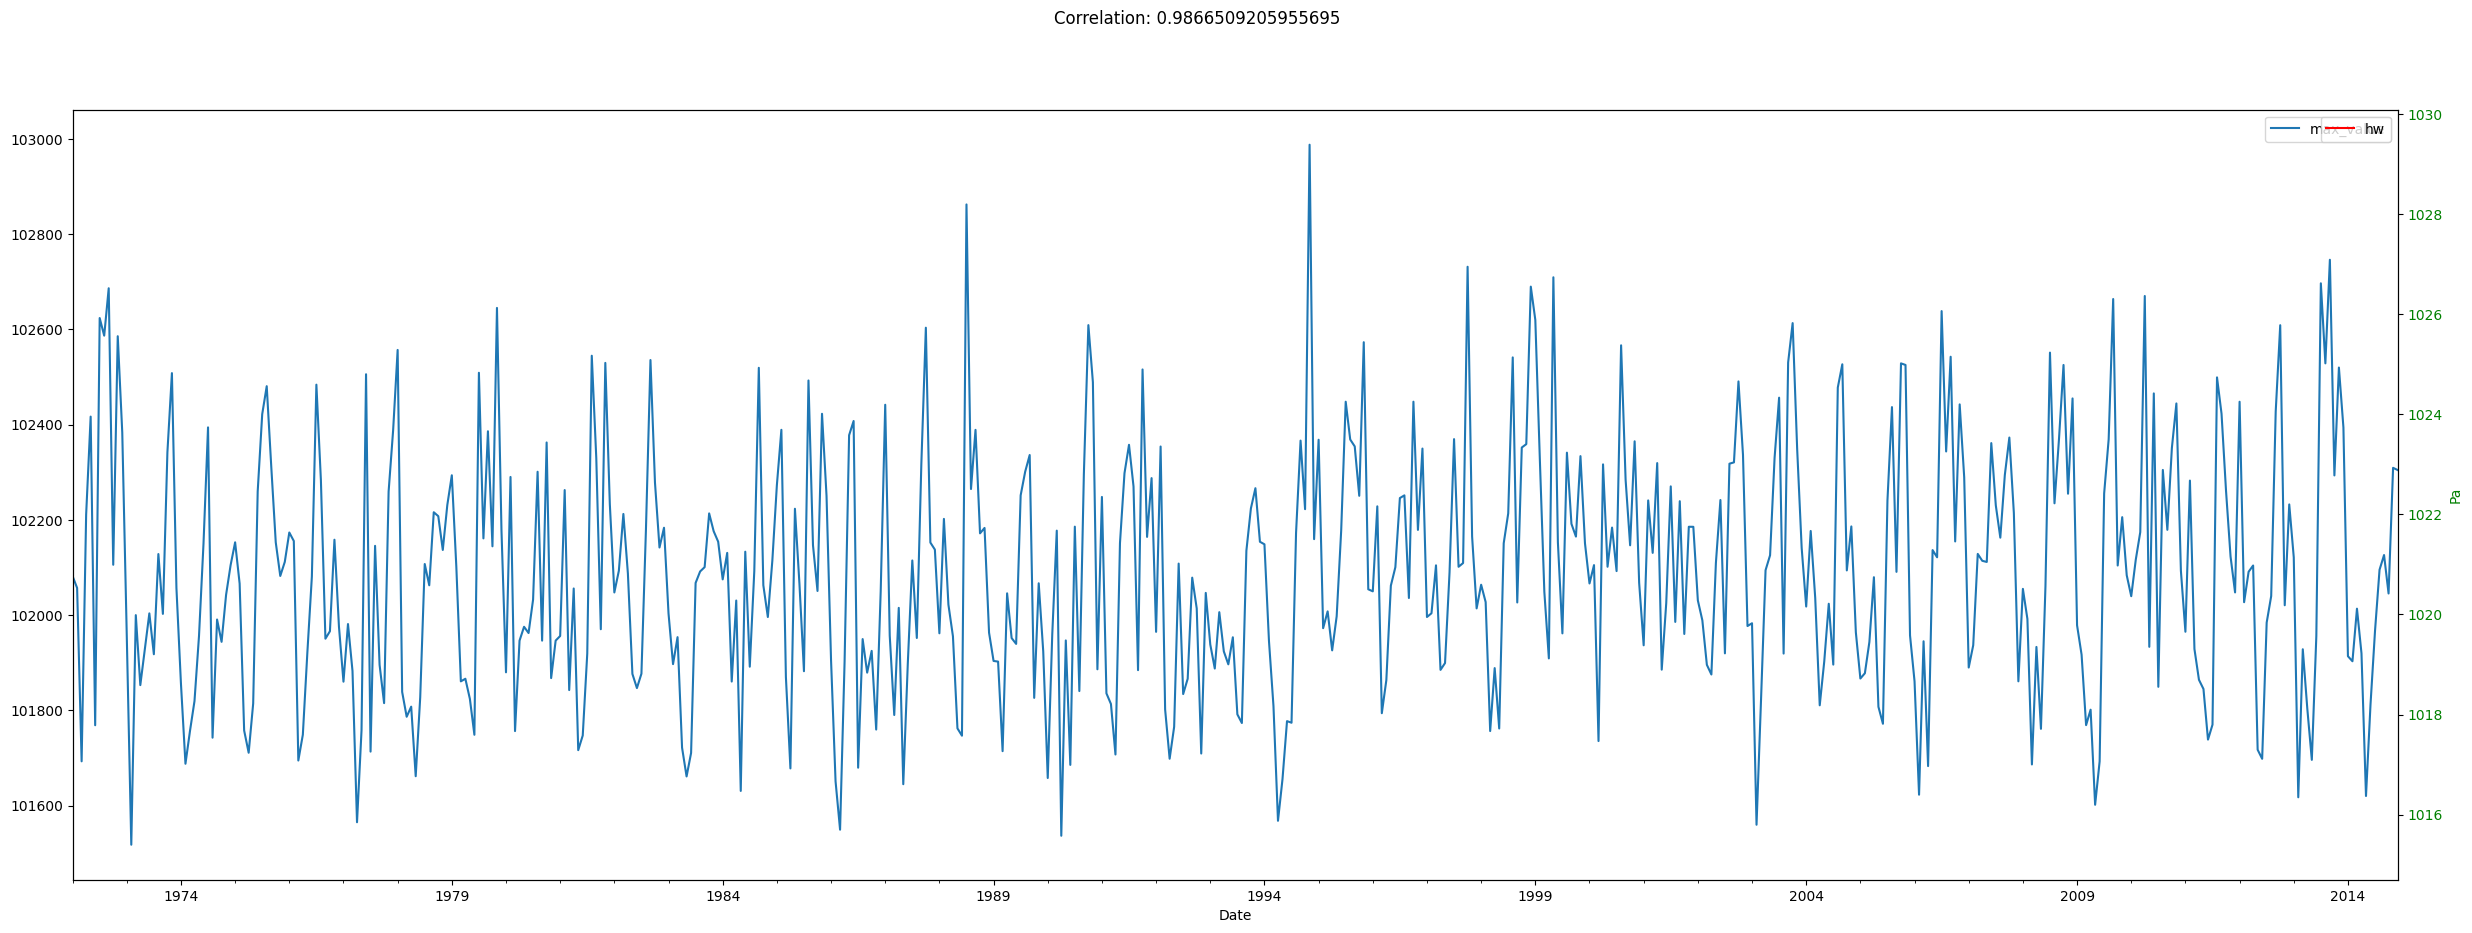

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))

ds_anticyclone = xr.open_mfdataset("data/03_primary/drivers/cmip6/EC-Earth3/historical/pacific_anticyclone/south_pacific_anticyclone_always_detect/monthly/*.nc").sel(time=slice("1972-01", "2014-12"))

ocean_cyclone_e3.get_index("psl").plot(y="max_value", ax=ax)
# Second Y-axis (right side)
ax2 = ax.twinx()
ax2.plot(ds_anticyclone.time, ds_anticyclone.pressure, color='red', label='hw') 
ax2.set_ylabel('Pa', color='green')
ax2.tick_params(axis='y', labelcolor='green')
corr = np.corrcoef(ocean_cyclone_e3.get_index("psl")["max_value"], ds_anticyclone.pressure)[0,1]
plt.suptitle(f"Correlation: {corr}")
plt.legend()
plt.show()
